# Daily Portfolio Value
- Start_val = 1000,000
- Start_date = 2009-1-1
- End_date = 2011-12-31
- Symbols = ['SPY','IBM', 'GOOG', 'GLD']
- Allocs = [0.4, 0.4, 0.1, 0.1]

# Portfolio statistics
- daily_rets = daily_rets[1:] # remove the first element (where return = 0)
- cum_ret = (port_val[-1] / port_val[0]) - 1
- avg_daily_ret = daily_rets.mean()
- std_daily_ret = daily_rets.std()
- sharpe_ratio

# Sharpe ratio
- Risk adjusted return
- All else being equal : lower risk is better | higher return is better
- SR also considers risk free rate of return
- S = E[R_p - R_f] / STD[R_p - R_f] (ex-ante, forward-looking)
- S = mean(daily_rets - daily_rf) / std(daily_rets - daily_rf) (using historical data)
- What is R_f? LIBOR | 3mo T-Bill | 0%
- Daily_rf? power(1+r, -252) - 1

- (summary) S = mean(daily_rets - daily_rf) / std(daily_rets) (adding constant to std can be removed)


### SR can vary widely depending on how frequently you sample
- SR is an annual measure
- SR_annualized = K * SR
- K = sqrt(#samples per year)
  - daily K = sqrt(252) | weekly K = sqrt(52) | monthly K = sqrt(12) 

### If we are using 'daily' data,
### SR = sqrt(252) * mean(daily_rests - daily_rf) / std(daily_rets)

# Optimizer
- Find 'minimum values' of functions
- Build parameterized models based on data
- Refine allocations to stocks in portfolios

## How to use an optimizer
- Provide a function to minimize
- Provide an initial guess
- Call the optimizer

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as spo

X=[4.], Y=[6.75]
X=[4.00000001], Y=[6.75000007]
X=[-1.], Y=[6.75]
X=[1.5], Y=[0.5]
X=[1.50000001], Y=[0.5]
Optimization terminated successfully    (Exit mode 0)
            Current function value: [0.5]
            Iterations: 2
            Function evaluations: 5
            Gradient evaluations: 2
Minima found at:
X=[1.5], Y=[0.5]
X=[0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8 1.9 2.  2.1 2.2
 2.3 2.4 2.5], Y=[1.5  1.31 1.14 0.99 0.86 0.75 0.66 0.59 0.54 0.51 0.5  0.51 0.54 0.59
 0.66 0.75 0.86 0.99 1.14 1.31 1.5 ]


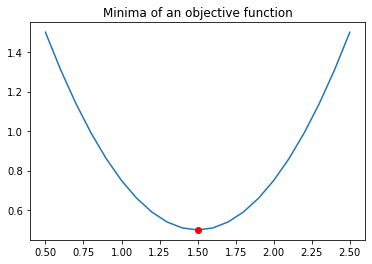

In [ ]:
#---------- Calling Optimizer Example --------------------

def f(X):
  """Given a scalar X, return some value (a real number)."""
  Y = (X - 1.5)**2 + 0.5
  print("X={}, Y={}".format(X, Y))
  return Y


def test_run():
  Xguess = 4.0
  min_result = spo.minimize(f, Xguess, method='SLSQP', options={'disp':True})
  print("Minima found at:")
  print("X={}, Y={}".format(min_result.x, min_result.fun))

  # Plot function values, mark minima
  Xplot = np.linspace(0.5, 2.5, 21)
  Yplot = f(Xplot)
  plt.plot(Xplot, Yplot)
  plt.plot(min_result.x, min_result.fun, 'ro')
  plt.title("Minima of an objective function")
  plt.show()

if __name__ == "__main__":
  test_run()

# Building a parameterized model
- f(x) = c_0 * x + c_1
- What are we minimizing? Error
- Minimizer finds coefficients


Original line: C0=4.0, C1=2.0
Optimization terminated successfully    (Exit mode 0)
            Current function value: 174.88445567918754
            Iterations: 5
            Function evaluations: 19
            Gradient evaluations: 5
Fitted line: C0=4.163754080307126, C1=0.5803253843122207


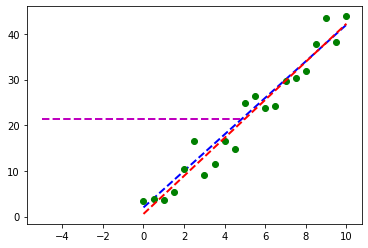

In [44]:
def error(line, data):
  """Compute error between given line model and observed data.

  Parameters
  ----------
  line: tuple/list/array (C0, C1) where C0 is slope and C1 is Y-intercept
  data: 2D array where each row is a point (x, y)

  Returns error as a single real value.
  """
  
  # Metric: Sum of squared Y-axis differences
  err = np.sum((data[:,1] - (line[0] * data[:,0] + line[1])) ** 2)
  return err



def error_poly(C, data):
  """Compute error between given polynomial and observed data.

  Parameters
  ----------
  C: numpy.poly1d object or equivalent array representing polynomial coefficients
  data: 2D array where each row is a point (x,y)

  Returns error as a single real value.
  """

  # Metric: Sum of squared Y-axis difference
  err = np.sum((data[:,1] - np.polyval(C, data[:,0])) ** 2)



def fit_line(data, error_func):
  """Fit a line to given data, using a supplied error function.

  Parameters
  ----------
  data: 2D array where each row is a point (X0, Y)
  error_func: function that computes the error between a line and observed data

  Returns line that minimizes the error function.
  """

  # Generate initial guess for line model
  l = np.float32([0, np.mean(data[:,1])]) # slope=0, intercept=mean(y values)

  # Plot initial guess
  x_ends = np.float32([-5,5])
  plt.plot(x_ends, l[0] * x_ends + l[1], 'm--', linewidth=2.0, label="Initial guess")

  # Call optimizer to minimize error function
  result = spo.minimize(error_func, l, args=(data,), method="SLSQP", options={'disp':True})
  return result.x



def fit_poly(data, error_func, degree=3):
  """Fit a polynomial to given data, using supplied error function.

  Parameters
  ----------
  data: 2D array where each row is a point (x,y)
  error_func: function that computes the error between a polynomial and observed data

  Returns polynomial that minimizes the error function.
  """

  # Generate initial guess for polynomial model (all coeffs = 1)
  Cguess = np.poly1d(np.ones(degree + 1, dtype = np.float32))

  # Plot initial guess
  x = np.linspace(-5,5,21)
  plt.plot(x, np.polyval(Cguess, x), 'm--', linewidth=2.0, label="Initial guess")

  # Call optimizer to minimize error function
  result = spo.minimize(error_func, Cguess, args=(data,), method='SLSQP', options={'disp':True})
  return np.poly(result.x) # Convert optimal result into a poly1d object



def test_run():
  # Define original line
  l_orig = np.float32([4,2])
  print("Original line: C0={}, C1={}".format(l_org[0], l_org[1]))
  Xorig = np.linspace(0,10,21)
  Yorig = l_orig[0] * Xorig + l_orig[1]
  plt.plot(Xorig, Yorig, 'b--', linewidth=2.0, label="Original line")

  # Generate noisy data points
  noise_sigma = 3.0
  noise = np.random.normal(0, noise_sigma, Yorig.shape)
  data = np.asarray([Xorig, Yorig + noise]).T
  plt.plot(data[:,0], data[:,1], 'go', label='Data points')

  # Fit a line to this data
  l_fit = fit_line(data, error)
  print("Fitted line: C0={}, C1={}".format(l_fit[0], l_fit[1]))
  plt.plot(data[:,0], l_fit[0] * data[:,0] + l_fit[1], 
           'r--', linewidth=2.0, label="Fitted line")

if __name__ == "__main__":
  test_run()